In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from imports import *

/home/kunal.jain001/miniconda3/envs/O/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2023-04-12 12:48:13.191003: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
import data_management
from data_management import load_stack
from data_management import load_data

import interactive_plot

import metrics
from metrics import statistics
from metrics import confusion_matrix
from metrics import error_distribution
from metrics import error_borders
from metrics import PR_curve

import generator_extended

import unet
from unet import load_model_unet
from unet import predict_net
from unet import get_unet
from unet import train
from unet import execute_predict

In [5]:
NPYPATH = '/raid/mpsych/RISTERLAB/fly_segmentation_experiments/data_dir/test2/pre_processing/npy/'
MODELPATH = '/raid/mpsych/RISTERLAB/fly_segmentation_experiments/classified_images/models/04-12-2/'
PRED_TESTING_PATH = '/raid/mpsych/RISTERLAB/fly_segmentation_experiments/classified_images/models/04-12-2/predictions/'
images_file = os.path.join(NPYPATH, 'original.npy')
labels_file = os.path.join(NPYPATH, 'mask.npy')

In [6]:
def get_random_images_and_labels(images, labels, num_imgs = 10):
    random_indices = np.random.choice(len(images), num_imgs)
    
    images = np.expand_dims(images, axis=3)
    labels = np.expand_dims(labels, axis=3)

    new_imgs = np.empty([num_imgs, 512, 512, 1])
    new_labels = np.empty([num_imgs, 512, 512, 1])
    z = 0
    for i in random_indices:
        new_imgs[z] = images[i]
        new_labels[z] = labels[i]
        z = z + 1
    return new_imgs, new_labels

In [7]:
images = np.load(images_file)
labels = np.load(labels_file)

In [8]:
random_images, random_labels = get_random_images_and_labels(images, labels, num_imgs=1200)

In [9]:
test_img_num = int(len(random_images)/2)

In [10]:
imgs_train = random_images[0:test_img_num]
imgs_mask_train = random_labels[0:test_img_num]
imgs_test = random_images[test_img_num:]
imgs_mask_test = random_labels[test_img_num:]

In [11]:
def normalize_image(a):
    a /= a.max()
    return a

In [12]:
for i in range(test_img_num):
    imgs_train[i] = normalize_image(imgs_train[i])
    imgs_test[i] = normalize_image(imgs_test[i])

print(imgs_train.min(), imgs_train.max())
print(imgs_mask_train.min(), imgs_mask_train.max())
print(imgs_test.min(), imgs_test.max())
print(imgs_mask_test.min(), imgs_mask_test.max())

0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0


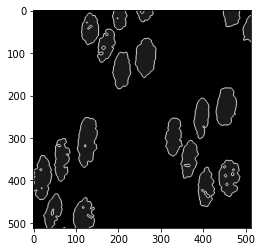

In [13]:
plt.figure(figsize=(7,4))
plt.imshow(imgs_mask_test[0,:,:,0], cmap='gray')
bimg = mh.borders(imgs_mask_test[0,:,:,0]).astype(int)
res = plt.imshow(bimg, alpha=0.9, cmap='gray')

In [14]:
model = get_unet(0.0005, diceloss=False, jaccardloss=False, focalloss=False, customloss=False)

2023-04-12 12:48:16.979962: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-04-12 12:48:17.190961: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:87:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-04-12 12:48:17.193617: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:90:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-04-12 12:48:17.193640: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-04-12 12:48:17.196862: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-04-12 

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout2d (SpatialDropo (None, 512, 512, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 32) 9248        spatial_dropout2d[0][0]          
______________________________________________________________________________________________

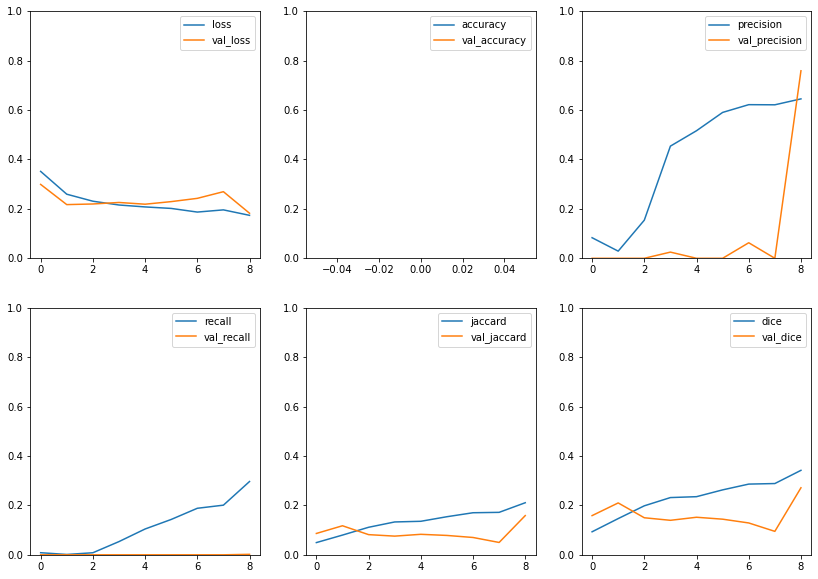

iteration 9
loss 0.17386925220489502 loss_val 0.1823563575744629
acc None acc_val None
prec 0.6451555490493774 prec_val 0.7589055895805359
rec 0.29658079147338867 rec_val 0.0019091125577688217
jaccard 0.2107045203447342 jaccard_val 0.15862594544887543
dice 0.3418332636356354 dice_val 0.27129441499710083
time per epoch: 13.319615840911865
Epoch 10/1000
  5/100 [>.............................] - ETA: 6s - loss: 0.1620 - accuracy: 0.9246 - iou: 0.2285 - iou_thresholded: 0.2428 - keras_precision: 0.6534 - keras_recall: 0.3073 - keras_jaccard_coef: 0.2182 - keras_dice_coef: 0.3557
Epoch 00010: saving model to /raid/mpsych/RISTERLAB/fly_segmentation_experiments/classified_images/models/04-12-2/weights.10-0.16.hdf5
 10/100 [==>...........................] - ETA: 7s - loss: 0.1597 - accuracy: 0.9218 - iou: 0.2287 - iou_thresholded: 0.1927 - keras_precision: 0.6620 - keras_recall: 0.2320 - keras_jaccard_coef: 0.2191 - keras_dice_coef: 0.3567batch 10 of 100 ...

Epoch 00010: saving model to /rai

In [ ]:
train(model, imgs_train, imgs_mask_train, imgs_test, imgs_mask_test,
      MODELPATH, 4, 1000, verbosity=1, 
      perform_flipping=True, perform_rotation=True, to_dir=False, train_on_borders=False)

In [ ]:
pred = execute_predict(model, imgs_test, stepsize=512, resize_shortest=True, extensive=False)

In [ ]:
pred_file = os.path.join(MODELPATH, '4-12-pred.npy')

np.save(pred_file, pred)

In [ ]:
cmatrix = confusion_matrix(pred, imgs_mask_test)

In [ ]:
statistics(cmatrix)

In [ ]:
error_distribution(model, imgs_test, imgs_mask_test, extensive=True, figsize=(15,10))

In [ ]:
PR_curve(pred, imgs_mask_test)

In [ ]:
input_img, gt = get_random_images_and_labels(images, labels, num_imgs=1)

In [ ]:
input_img = np.squeeze(input_img, axis=(0,))
gt = np.squeeze(gt, axis=(0,))

In [ ]:
plt.figure(figsize = (15,15))
plt.imshow(input_img, cmap='gray')

print(input_img.shape)
res = execute_predict(model, input_img.reshape(1,512,512,1).astype(float)/255.)
print(res.min(), res.max())

if (res.max() > 0.5):    
    random_string = ''.join(random.choices(string.ascii_uppercase + string.digits, k=7))
    testing_path = PRED_TESTING_PATH + random_string + '/'

    if not os.path.isdir(testing_path):
        os.mkdir(testing_path)
    print('saving images at ' + testing_path)

    res[res>0.5]=1
    res[res<=0.5]=0

    plt.figure(figsize = (15,15))
    plt.imshow(res[0,:,:,0], cmap='gray')

    plt.figure(figsize = (15,15))
    plt.imshow(gt[:,:,0], cmap='gray')

    cv2.imwrite(os.path.join(testing_path, 'example_img_raw.png'), input_img)
    cv2.imwrite(os.path.join(testing_path, 'example_img_gt.png'), gt[:,:,0]*255)
    cv2.imwrite(os.path.join(testing_path, 'example_img.png'), res[0,:,:,0]*255.)
else:
    print("Not a good segmentation result :(")